In [8]:
import requests
import pandas as pd
import io
import zipfile
import yfinance as yf
import statsmodels.api as sm
from bs4 import BeautifulSoup


def get_factor_links(region):
  
    factors_dict = {
        'Fama/French 5 Factors (2x3)': 'ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip',
        'Fama/French Developed 5 Factors': 'ftp/Developed_5_Factors_CSV.zip',
        'Fama/French Developed ex US 5 Factors': 'ftp/Developed_ex_US_5_Factors_CSV.zip',
        'Fama/French European 5 Factors': 'ftp/Europe_5_Factors_CSV.zip',
        'Fama/French Japanese 5 Factors': 'ftp/Japan_5_Factors_CSV.zip',
        'Fama/French Asia Pacific ex Japan 5 Factors': 'ftp/Asia_Pacific_ex_Japan_5_Factors_CSV.zip',
        'Fama/French North American 5 Factors': 'ftp/North_America_5_Factors_CSV.zip'
    }

    mom_dict = {
        'Momentum Factor (Mom)': 'ftp/F-F_Momentum_Factor_CSV.zip',
        'Developed Momentum Factor (Mom)': 'ftp/Developed_Mom_Factor_CSV.zip',
        'Developed ex US Momentum Factor (Mom)': 'ftp/Developed_ex_US_Mom_Factor_CSV.zip',
        'European Momentum Factor (Mom)': 'ftp/Europe_Mom_Factor_CSV.zip',
        'Japanese Momentum Factor (Mom)': 'ftp/Japan_Mom_Factor_CSV.zip',
        'Asia Pacific ex Japan Momentum Factor (Mom)': 'ftp/Asia_Pacific_ex_Japan_MOM_Factor_CSV.zip',
        'North American Momentum Factor (Mom)': 'ftp/North_America_Mom_Factor_CSV.zip'
    }

    region_dict = {
        'North America': ('Fama/French North American 5 Factors', 'North American Momentum Factor (Mom)'),
        'Europe': ('Fama/French European 5 Factors', 'European Momentum Factor (Mom)'),
        'Japan': ('Fama/French Japanese 5 Factors', 'Japanese Momentum Factor (Mom)'),
        'Asia Pacific ex Japan': ('Fama/French Asia Pacific ex Japan 5 Factors', 'Asia Pacific ex Japan Momentum Factor (Mom)'),
        'Developed ex US': ('Fama/French Developed ex US 5 Factors', 'Developed ex US Momentum Factor (Mom)'),
        'Developed Markets': ('Fama/French Developed 5 Factors', 'Developed Momentum Factor (Mom)'),
        'Global': ('Fama/French 5 Factors (2x3)', 'Momentum Factor (Mom)')
    }

    factor_name, momentum_name = region_dict[region]
    factor_url = factors_dict[factor_name]
    momentum_url = mom_dict[momentum_name]
    return factor_url, momentum_url


def download_zip(url, file_path):
    response = requests.get(url + "/" + file_path)
    if response.status_code == 200:
        zipfile_in_memory = io.BytesIO(response.content)
        with zipfile.ZipFile(zipfile_in_memory, "r") as zip_ref:
            csv_filename = zip_ref.namelist()[0]
            with zip_ref.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file, skiprows=6)
    else:
        raise Exception("Failed to download the file")

    return df


def clean_data(df):
    index_to_drop = df[df.iloc[:, 0] == " Annual Factors: January-December"].index
    df = df.iloc[:index_to_drop[0]]
    df = df.rename(columns={'Unnamed: 0': 'Date'})
    df['Date'] = df['Date'].str.strip()
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
    date_threshold = df['Date'].max() - pd.DateOffset(months=60)
    df = df[df['Date'] >= date_threshold]
    return df


def download_historical_prices(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date - pd.DateOffset(months=1), end=end_date, interval="1mo")
    df['RI'] = df['Adj Close'].pct_change()
    df = df.reset_index()
    return df

def merge_factors_and_momentum(factors_df, momentum_df):
    merged_df = factors_df.merge(momentum_df, on='Date')
    df_columns = merged_df.columns.tolist()
    df_columns.remove('Date')
    merged_df[df_columns] = merged_df[df_columns].astype(float)
    merged_df.loc[:, merged_df.columns != 'Date'] /= 100

    return merged_df



def run_regression(merged_df):
    y = merged_df['RI-RF']
    X = sm.add_constant(merged_df[['Mkt-RF', 'SMB', 'HML']])
    model = sm.OLS(y, X).fit()
    Alpha = model.params[0]
    Beta_Mkt = model.params[1]
    Beta_SMB = model.params[2]
    Beta_HML = model.params[3]
    Rf = merged_df['RF'].mean()
    print(model.summary())

    return model, Alpha, Beta_Mkt, Beta_SMB, Beta_HML, Rf



In [9]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french"
region = 'North America'
ticker = "AAPL"

factor_path, momentum_path = get_factor_links(region)
print(factor_path, momentum_path)

factors_df = download_zip(url, factor_path)
factors_df = clean_data(factors_df)

factors_df

ftp/North_America_5_Factors_CSV.zip ftp/North_America_Mom_Factor_CSV.zip


,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
331,2018-02-01,-3.95,-0.23,-2.74,0.86,-2.59,0.11
332,2018-03-01,-2.17,2.98,0.16,-0.46,-0.04,0.12
333,2018-04-01,0.35,0.46,1.36,-1.91,0.74,0.14
334,2018-05-01,2.51,2.86,-3.41,-1.37,-1.71,0.14
335,2018-06-01,0.39,0.18,-1.04,1.18,0.88,0.14
...,...,...,...,...,...,...,...
387,2022-10-01,7.96,1.44,7.66,1.10,6.64,0.23
388,2022-11-01,4.82,-1.21,0.85,3.54,2.54,0.29
389,2022-12-01,-6.30,0.31,1.77,0.14,3.92,0.33
390,2023-01-01,6.77,3.62,-3.52,-0.35,-4.20,0.35


In [10]:
momentum_df = download_zip(url, momentum_path)
momentum_df = clean_data(momentum_df)
momentum_df

,Date,WML
327,2018-02-01,3.64
328,2018-03-01,-1.23
329,2018-04-01,0.51
330,2018-05-01,4.00
331,2018-06-01,-1.30
...,...,...
383,2022-10-01,5.77
384,2022-11-01,-2.38
385,2022-12-01,4.02
386,2023-01-01,-12.72


In [11]:
start_date = factors_df['Date'].min()
end_date = factors_df['Date'].max()
hist_prices_df = download_historical_prices(ticker, start_date, end_date)
hist_prices_df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,RI
0,2018-01-01,42.540001,45.025002,41.174999,41.857498,39.741604,2638717600,NaN
1,2018-02-01,41.792500,45.154999,37.560001,44.529999,42.279003,3711577200,0.063847
2,2018-03-01,44.634998,45.875000,41.235001,41.945000,39.987057,2854910800,-0.054210
3,2018-04-01,41.660000,44.735001,40.157501,41.314999,39.386459,2664617200,-0.015020
4,2018-05-01,41.602501,47.592499,41.317501,46.717499,44.536774,2483905200,0.130764
...,...,...,...,...,...,...,...,...
56,2022-09-01,156.639999,164.259995,138.000000,138.199997,137.760773,2084722800,-0.119756
57,2022-10-01,138.210007,157.500000,134.369995,153.339996,152.852661,1868139700,0.109551
58,2022-11-01,155.080002,155.449997,134.380005,148.029999,147.559555,1724847700,-0.034629
59,2022-12-01,148.210007,150.919998,125.870003,129.929993,129.731918,1675731200,-0.120817


In [12]:
merged_df = merge_factors_and_momentum(factors_df, momentum_df)
merged_df

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
0,2018-02-01,-0.0395,-0.0023,-0.0274,0.0086,-0.0259,0.0011,0.0364
1,2018-03-01,-0.0217,0.0298,0.0016,-0.0046,-0.0004,0.0012,-0.0123
2,2018-04-01,0.0035,0.0046,0.0136,-0.0191,0.0074,0.0014,0.0051
3,2018-05-01,0.0251,0.0286,-0.0341,-0.0137,-0.0171,0.0014,0.0400
4,2018-06-01,0.0039,0.0018,-0.0104,0.0118,0.0088,0.0014,-0.0130
...,...,...,...,...,...,...,...,...
56,2022-10-01,0.0796,0.0144,0.0766,0.0110,0.0664,0.0023,0.0577
57,2022-11-01,0.0482,-0.0121,0.0085,0.0354,0.0254,0.0029,-0.0238
58,2022-12-01,-0.0630,0.0031,0.0177,0.0014,0.0392,0.0033,0.0402
59,2023-01-01,0.0677,0.0362,-0.0352,-0.0035,-0.0420,0.0035,-0.1272


In [13]:
start_date = factors_df['Date'].min()
end_date = factors_df['Date'].max()
hist_prices_df = download_historical_prices(ticker, start_date, end_date)

merged_df = merged_df.merge(hist_prices_df, on='Date')
merged_df['RI-RF'] = merged_df['RI'] - merged_df['RF']

model, Alpha, Beta_Mkt, Beta_SMB, Beta_HML, Rf = run_regression(merged_df)

print("Alpha: ", Alpha)
print("Beta Mkt: ", Beta_Mkt)
print("Beta SMB: ", Beta_SMB)
print("Beta HML: ", Beta_HML)
print("Rf (Monthly): ", Rf)

[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                  RI-RF   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     31.07
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           5.83e-12
Time:                        10:21:01   Log-Likelihood:                 86.617
No. Observations:                  60   AIC:                            -165.2
Df Residuals:                      56   BIC:                            -156.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')


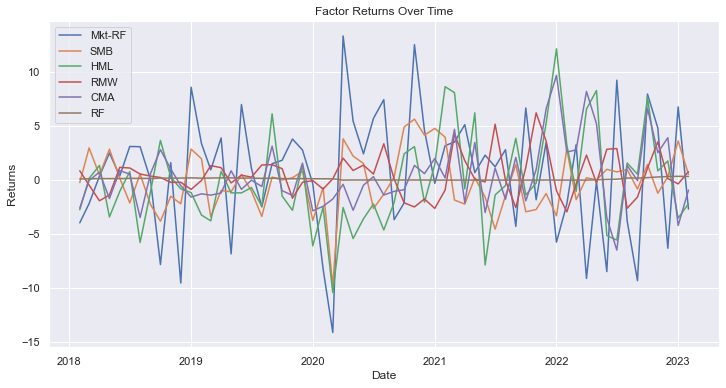

In [15]:
factors_to_plot = factors_df.copy()
factors_to_plot.set_index('Date', inplace=True)
factors_to_plot = factors_to_plot.apply(pd.to_numeric)

plt.figure(figsize=(12, 6))
plt.plot(factors_to_plot)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Factor Returns Over Time')
plt.legend(factors_to_plot.columns)
plt.show()


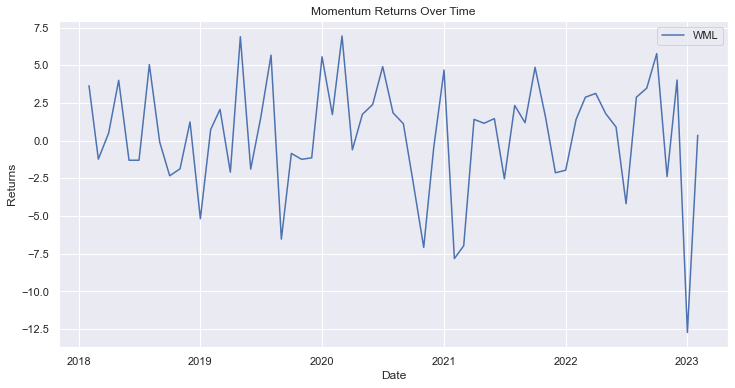

In [16]:
momentum_to_plot = momentum_df.copy()
momentum_to_plot.set_index('Date', inplace=True)
momentum_to_plot = momentum_to_plot.apply(pd.to_numeric)

plt.figure(figsize=(12, 6))
plt.plot(momentum_to_plot)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Momentum Returns Over Time')
plt.legend(momentum_to_plot.columns)
plt.show()


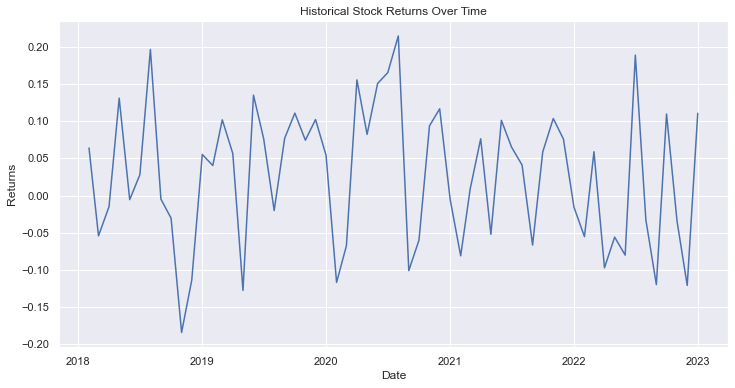

In [17]:
stock_returns_to_plot = hist_prices_df[['Date', 'RI']].copy()
stock_returns_to_plot.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(stock_returns_to_plot)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Historical Stock Returns Over Time')
plt.show()


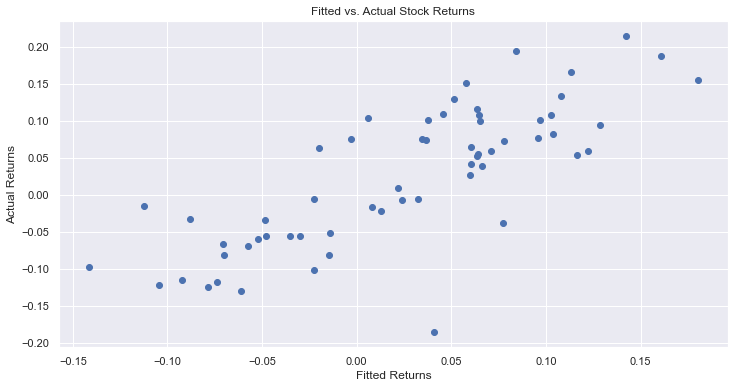

In [18]:
merged_df['Fitted'] = model.predict(sm.add_constant(merged_df[['Mkt-RF', 'SMB', 'HML']]))

plt.figure(figsize=(12, 6))
plt.scatter(merged_df['Fitted'], merged_df['RI-RF'])
plt.xlabel('Fitted Returns')
plt.ylabel('Actual Returns')
plt.title('Fitted vs. Actual Stock Returns')
plt.show()
